In [1]:
pip install heartpy

In [2]:
pip install mediapipe

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# insert this line of code to import the different function that we will use (they are functions that we saved in the files .py)
import sys
sys.path.insert(0,'/content/drive/MyDrive/tesi_UBFC-RPPG/function')

# FUNCTION

In [5]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mediapipe
import statistics
import heartpy as hp
import os

#from SIGNAL_extraction_function import *
from VIDEO_load_function import *
from VIDEO_PreProcessing_function import *
from UBFC_RPPG_function import *
from google.colab.patches import cv2_imshow
from roi_mediapipe import *
from lpa_ica import *

from GREEN_1 import *
from POS_1 import *
from CHROM_1 import *
from ICA_1 import *
from PVB import *
from LGI import *

In [6]:
# EXTRACT THE SIGNAL FROM THE CROPPED IMAGES (AVERAGE OF THE PIXEL VALUES) (FOR PLOTTING SIGNAL ARE SAVED IN )
# comodo salvare tutti i diversi segnali associato ad uno stesso video in un singolo dizionario
def signal_extraction_plotting(cropped_video, num_valid_pixel):
  signal = {'R':[], 'G':[], 'B':[]}
  for i in range(cropped_video.shape[0]):
    signal['R'].append(np.sum(cropped_video[i,:,:,0])/num_valid_pixel[i])
    signal['G'].append(np.sum(cropped_video[i,:,:,1])/num_valid_pixel[i])
    signal['B'].append(np.sum(cropped_video[i,:,:,2])/num_valid_pixel[i])

  return signal

In [7]:
import scipy
import scipy.io
from scipy.signal import butter
def PB_filt(signal, LPF=0.75, HPF=2.5, fs=30):
  [b, a] = butter(1, [LPF / fs * 2, HPF / fs * 2], btype='bandpass')
  output = scipy.signal.filtfilt(b, a, np.double(signal))

  return output

In [8]:
def algorithm(signal_RGB,ROI_tensor_im, method):
  FS = 30

  if method == 'POS':
    rPPG = POS(signal_RGB,FS)
  elif method == 'CHROM':
    rPPG = CHROME(signal_RGB,FS)
  elif method == 'GREEN':
    rPPG = GREEN(signal_RGB,FS)
  elif method == 'ICA':
    rPPG = ICA(signal_RGB,FS)
  elif method == 'PBV':
    rPPG = PBV(ROI_tensor_im)
  elif method == 'LGI':
    rPPG = LGI(ROI_tensor_im)


  rPPG_filtered = PB_filt(rPPG, LPF=0.75, HPF=2.5, fs=30)

  sample_rate=30
  smooth_freqs, smooth_power_spectrum, max_freq, max_power = compute_power_spectrum(rPPG_filtered, sample_rate)

  plt.figure(figsize=(10, 6))
  plt.plot(smooth_freqs, smooth_power_spectrum)
  plt.title('Power Spectrum of the Combined Sine Waves')
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Power')
  plt.grid(True)
  plt.show()

  import pickle
  with open("smooth_freqs_1", "wb") as fp:   #Pickling
    pickle.dump(smooth_freqs, fp)

  import pickle
  with open("smooth_power_spectrum_1", "wb") as fp1:   #Pickling
    pickle.dump(rPPG_filtered, fp1)

  return max_freq

In [9]:
def skin_segmentation_2(image, roi):
  mp_face_mesh = mediapipe.solutions.face_mesh
  face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)
  results = face_mesh.process(image)
  landmarks = results.multi_face_landmarks[0]

  #define the roi to segment
  if roi == 'face':
    face_oval = mp_face_mesh.FACEMESH_FACE_OVAL

    df = pd.DataFrame(list(face_oval), columns = ["p1", "p2"])
    routes_idx = []
    p1 = df.iloc[0]["p1"]
    p2 = df.iloc[0]["p2"]

    for i in range(0, df.shape[0]):
      obj = df[df["p1"] == p2]
      p1 = obj["p1"].values[0]
      p2 = obj["p2"].values[0]
      route_idx = []
      route_idx.append(p1)
      route_idx.append(p2)
      routes_idx.append(route_idx)

  if roi == 'fore_head':
    #fore_head = [(103,104),(104,105),(105,66),(66,107),(107,9),(9,336),(336,296),(296,334),(334,333),(333,332),(332,297),(297,338),(338,10),(10,109),(109,67),(67,103)] #ROI molto grande
    #fore_head = [(67,69),(69,108),(108,151),(151,337),(337,299),(299,297),(297,338),(338,10),(10,109),(109,67)] #risultati final_mediapipe
    #fore_head = [(67,69),(69,66),(66,107),(107,9),(9,336),(336,296),(296,299),(299,297),(297,338),(338,10),(10,109),(109,67)]
    fore_head = [(109,108),(108,107),(107,9),(9,336),(336,337),(337,338),(338,10),(10,109)]
    routes_idx = fore_head

  if roi == 'cheek_sx':
    #cheek_sx = [(117,123),(123,147),(147,187),(187,207),(207,216),(216,206),(206,203),(203,142),(142,100),(100,120),(120,119),(119,118),(118,117)] #ROI molto grande
    cheek_sx = [(117,123),(123,147),(147,187),(187,205),(205,36),(36,142),(142,100),(100,120),(120,119),(119,118),(118,117)]
    #cheek_sx = [(230,120),(120,100),(100,36),(36,205),(205,50),(50,118),(118,230)] #piccole spostate verso centro
    #cheek_sx = [(117,123),(123,187),(187,205),(205,101),(101,118),(118,117)] #risultati final_mediapipe
    routes_idx = cheek_sx

  if roi == 'cheek_dx':
    #cheek_dx = [(346,352),(352,411),(411,427),(427,436),(436,426),(426,423),(423,371),(371,329),(329,349),(349,348),(348,347),(347,346)] #ROI molto grande
    cheek_dx = [(346,352),(352,411),(411,425),(425,266),(266,329),(329,349),(349,348),(348,347),(347,346)]
    #cheek_dx = [(450,349),(349,329),(329,266),(266,425),(425,280),(280,347),(347,450)]  #piccole spostate verso centro
    #cheek_dx = [(340,352),(352,280),(280,425),(425,266), (266,330), (330,347), (347,346),(346,340)] #risultati final_mediapipe
    routes_idx = cheek_dx

  if roi == 'chin':
    #chin = [(194,32),(32,140),(140,171),(171,175),(175,396),(396,369),(369,262),(262,418),(418,421),(421,200),(200,201),(201,194)]
    chin = [(83,201),(201,208),(208,199),(199,428),(428,421),(421,313),(313,18),(18,83)]
    routes_idx = chin

  #############################################################################
  #extaction of the ROI
  routes = []
  for source_idx, target_idx in routes_idx:

    source = landmarks.landmark[source_idx]
    target = landmarks.landmark[target_idx]
    relative_source = (int(image.shape[1] * source.x), int(image.shape[0] * source.y))
    relative_target = (int(image.shape[1] * target.x), int(image.shape[0] * target.y))
    #cv2.line(image, relative_source, relative_target, (255, 255, 255), thickness = 2)
    routes.append(relative_source)
    routes.append(relative_target)

  mask = np.zeros((image.shape[0], image.shape[1]))
  mask = cv2.fillConvexPoly(mask, np.array(routes), 1)
  mask = mask.astype(bool)
  out = np.zeros_like(image)
  out[mask] = image[mask]

  return out

In [10]:
'''
estensione del skin segmentation non ad una sola immagine, ma viene applicata ad un video -> quindi abbiamo richiamato la funzione definita sopra per astenderla a tutti i frame del video
'''
def skin_segm_video_2(video, roi, tensor_shape=True):
  cropped_image = []
  heigth = 0
  width = 0
  for iii in range(video.shape[0]):
    temp = skin_segmentation_2(video[iii], roi)
    [min_x, max_x, min_y, max_y] = valid_image(temp)

    temp_width = max_x - min_x
    temp_heigth = max_y - min_y

    if temp_heigth > heigth:
      heigth = temp_heigth
    if temp_width > width:
      width = temp_width

    cropped_image.append(temp)
  cropped_image = np.array(cropped_image)
  print('SEGMENTATION: DONE')

  final_image = []
  number_valid_pixel = []
  for k in range(cropped_image.shape[0]):
    [min_x, max_x, min_y, max_y] = valid_image(cropped_image[k])

    # to count the pixels != 0 so in the mean we consider only the number of valid pixels
    mask = np.any(cropped_image[k] != 0, axis=-1)
    non_zero_coords = np.argwhere(mask).shape[0]
    number_valid_pixel.append(non_zero_coords)

    if tensor_shape:
      final_image.append(cropped_image[k, min_x:min_x+width ,min_y:min_y+heigth , :])
    else:
      final_image.append(cropped_image[k, min_x:max_x, min_y:max_y , :])

  print('CROPPING: DONE')

  return np.array(final_image), number_valid_pixel

In [11]:
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt

def compute_power_spectrum(signal, sample_rate):
    """Compute the power spectrum of a signal and find the frequency corresponding to the maximum peak."""
    # Compute the FFT of the signal
    plt.subplots()
    plt.plot(signal)

    fft_result = np.fft.fft(signal)

    # Compute the power spectrum (magnitude squared of the FFT result)
    power_spectrum = np.abs(fft_result) ** 2

    # Get the frequencies corresponding to the FFT result
    freqs = np.fft.fftfreq(len(signal), d=1/sample_rate)

    # Only keep the positive frequencies and their corresponding power spectrum values
    pos_mask = (freqs > 0) & (freqs <= 4)
    freqs = freqs[pos_mask]
    power_spectrum = power_spectrum[pos_mask]

    # Interpolate to smooth the frequency domain
    interp_func = interp1d(freqs, power_spectrum, kind='cubic', fill_value='extrapolate')
    smooth_freqs = np.linspace(freqs[0], freqs[-1], num=500)  # More points for a smoother result
    smooth_power_spectrum = interp_func(smooth_freqs)

    # Find the frequency corresponding to the maximum peak
    max_index = np.argmax(smooth_power_spectrum)
    max_freq = smooth_freqs[max_index]
    max_power = smooth_power_spectrum[max_index]

    return  smooth_freqs, smooth_power_spectrum, max_freq*60, max_power


# CODE

## IMPORT VIDEO

In [12]:
patient = 18
[video, fps_video] = import_video('/content/drive/MyDrive/DATASET_2/subject' + str(patient) + '/vid.avi')

In [13]:
video_RGB = []
for i in video:
  video_RGB.append(cv2.cvtColor(i, cv2.COLOR_BGR2RGB))
video_RGB = np.array(video_RGB)
leng = 100 # it's used later to cut the video othewise it's too long and we run out of memory

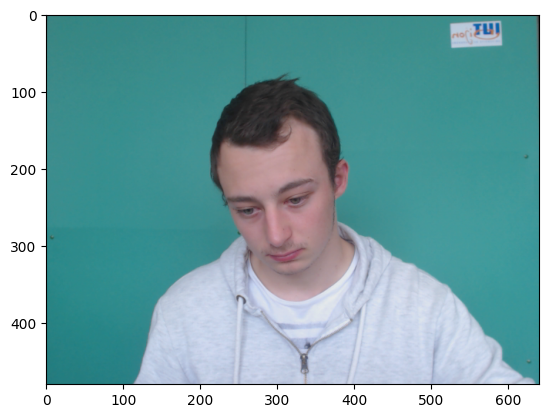

In [14]:
plt.imshow(video_RGB[0])

## GROUND-TRUTH

In [15]:
def PPG_to_HR(signal, plotting = True, type = 'Tool_box'):
  if type == 'Tool_box':
    working_data, measures = hp.process(signal, sample_rate=30)
    HR_toolbox = measures['bpm']
    if plotting:
      hp.plotter(working_data, measures)
    return HR_toolbox
  else:
    print('type: Tool_box')

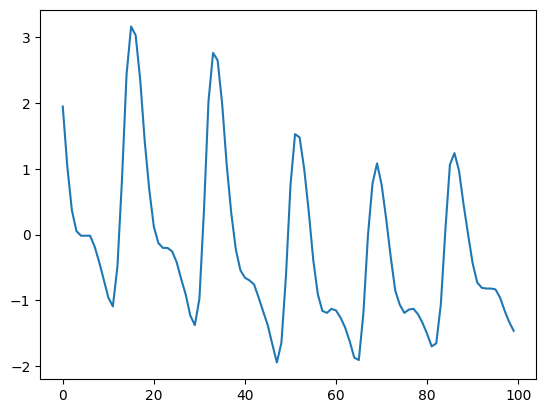

In [16]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

GT_rPPG = np.array(import_UBFC_RPPG_ground_truth(num_patient=patient))
sample_rate = 30
smooth_freqs, smooth_power_spectrum, GT_HR, max_power = compute_power_spectrum(GT_rPPG[0][:leng], sample_rate)

## PRE-ALLOCATE DATAFRAME SPACE

In [17]:
# Preallocate a DataFrame with NaN values (first iteration)
# columns : ROIs
# rows : GT (ground truth), greemn, ica, pos, chrom
rows = 7
columns = ['fore_head', 'cheek_sx', 'cheek_dx']
#columns = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9']
df = pd.DataFrame(np.nan, index=range(rows), columns=columns)
df.loc[0] = [GT_HR]*3

# Specify the filename
filename = '/content/drive/MyDrive/tesi_UBFC-RPPG/tesi/mediapipe/new_mediapipe_patttttt_' + str(patient) + '.csv'
#filename = '/content/drive/MyDrive/tesi_UBFC-RPPG/pre_processing/merged_code/mediapipe_new_' + str(patient) + '.csv'

# Check if the file exists
if os.path.exists(filename):
    print(f"The file '{filename}' exists.")
else:
  print(f"The file '{filename}' does not exist.")
  df.to_csv(filename, index=False)

The file '/content/drive/MyDrive/tesi_UBFC-RPPG/tesi/mediapipe/new_mediapipe_patttttt_18.csv' exists.


## ROI EXCTRACTION

### 1. ROI MEDIAPIPE

In [18]:
import time

In [19]:
# we need to re-run the code for each ROI otherwise we will run out of memory.
# So we pre-allocate space for the dataframe only with the first iteration; then we import it and add the new values
#selected_roi = 'cheek_dx'
#selected_roi = 'cheek_sx'
selected_roi = 'fore_head'
#selected_roi = 'chin'
#selected_roi = 'face'

start_time = time.time()

ROI_tensor_im, num_valid_pixel = skin_segm_video_2(video_RGB[:100], roi=selected_roi)
signal_RGB = signal_extraction_plotting(ROI_tensor_im, num_valid_pixel)
print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


SEGMENTATION: DONE
CROPPING: DONE
--- 6.053584814071655 seconds ---


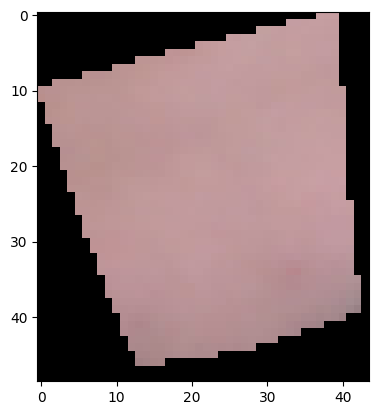

In [20]:
plt.imshow(ROI_tensor_im[0])

In [21]:
#x_coor = [30,40,50,30,40,50,30,40,50]
#y_coor = [80,80,80,90,90,90,100,100,100]
#fig, ax = plt.subplots()
#ax.imshow(ROI_tensor_im[0])
#ax.scatter(x_coor, y_coor, color='b',s=4) #coordinates x, y

In [22]:
signal_RGB = signal_extraction_plotting(ROI_tensor_im, num_valid_pixel)
#signal_RGB.keys() #raw signals (RGB channels)

In [23]:
df = pd.read_csv(filename)

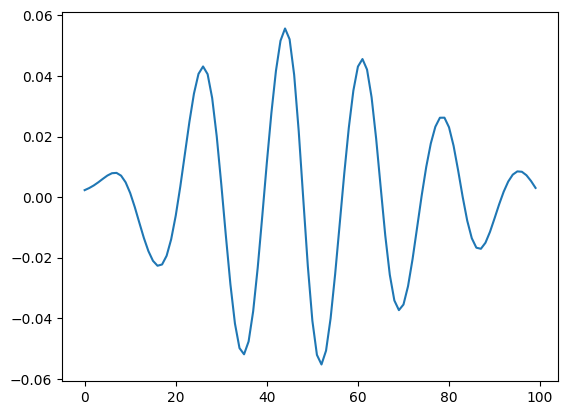

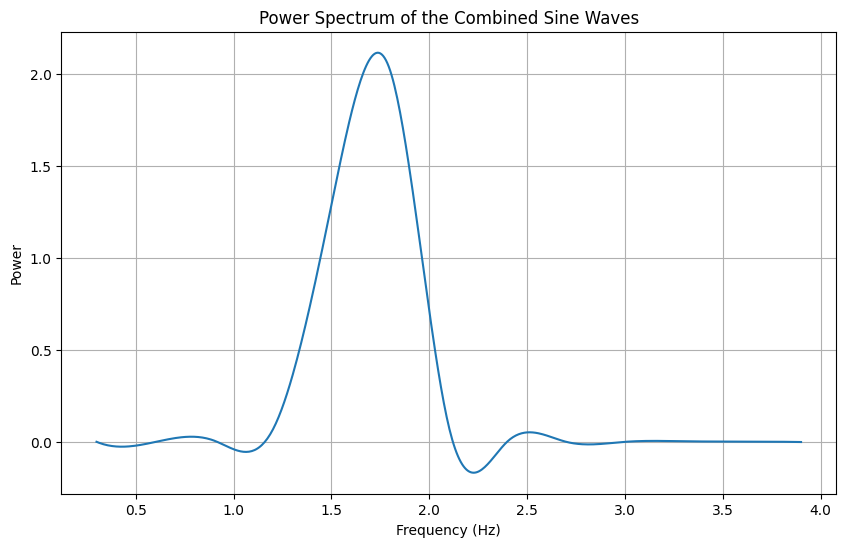

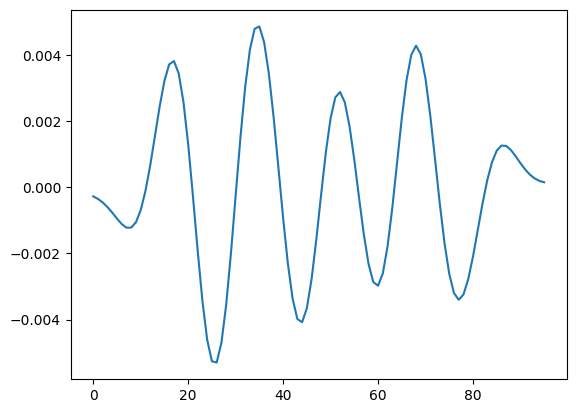

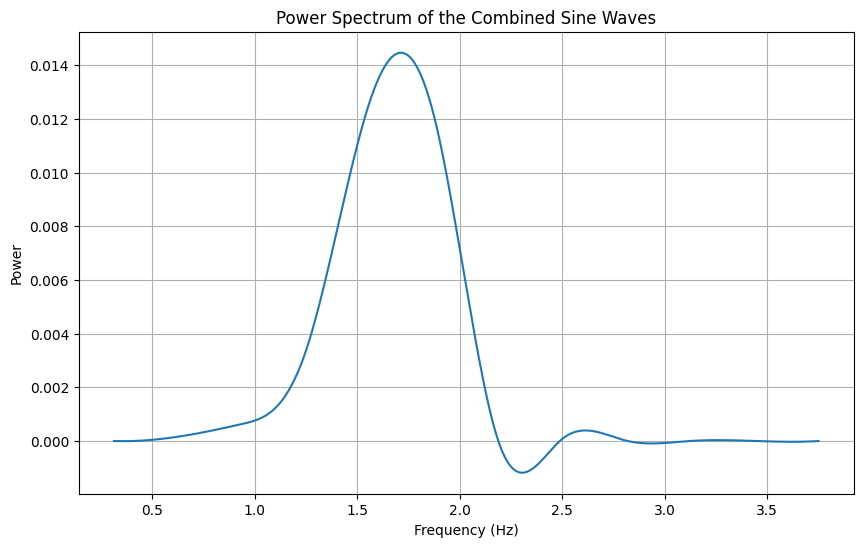

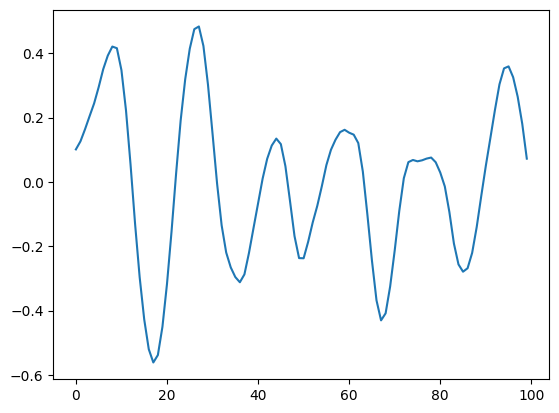

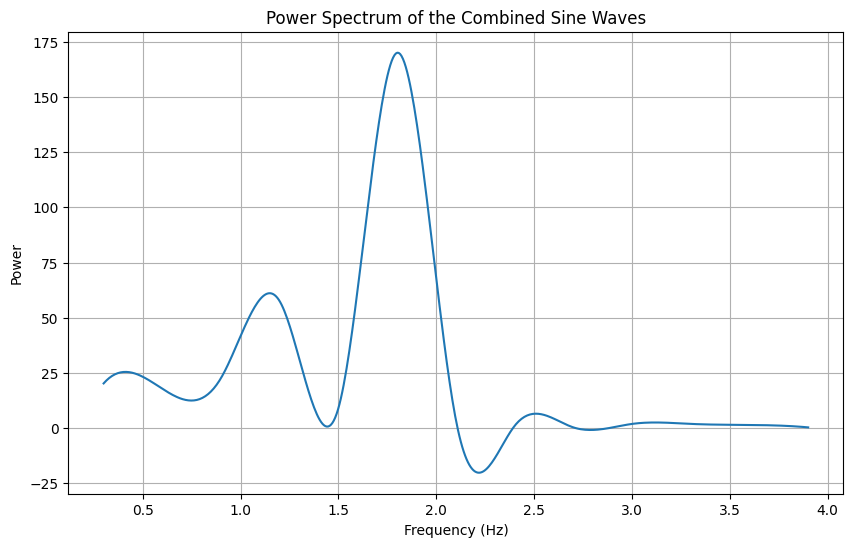

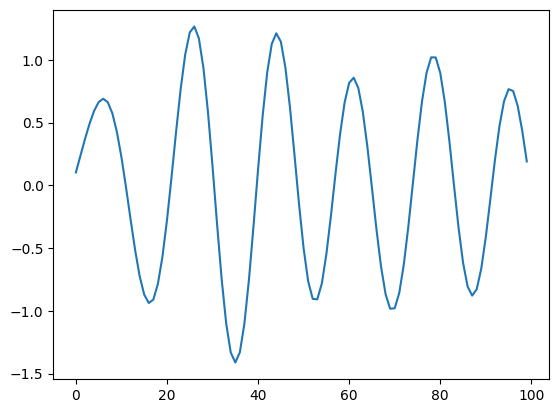

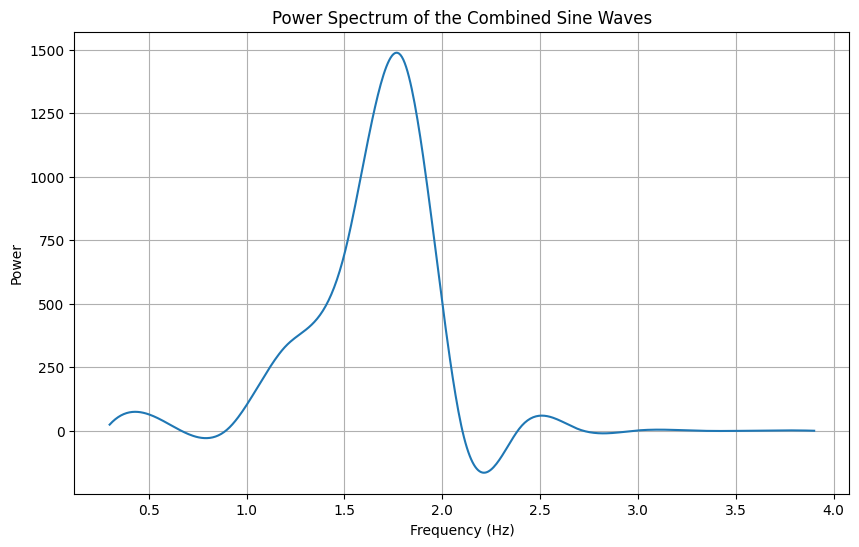

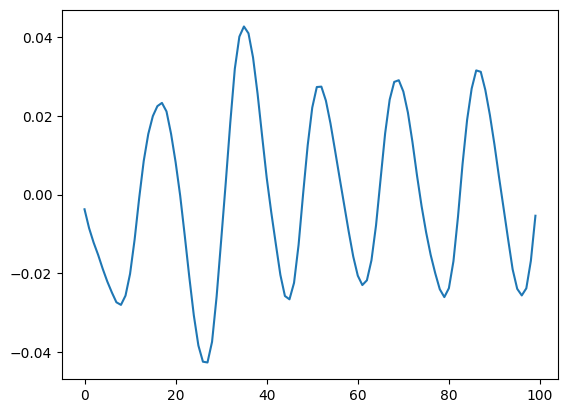

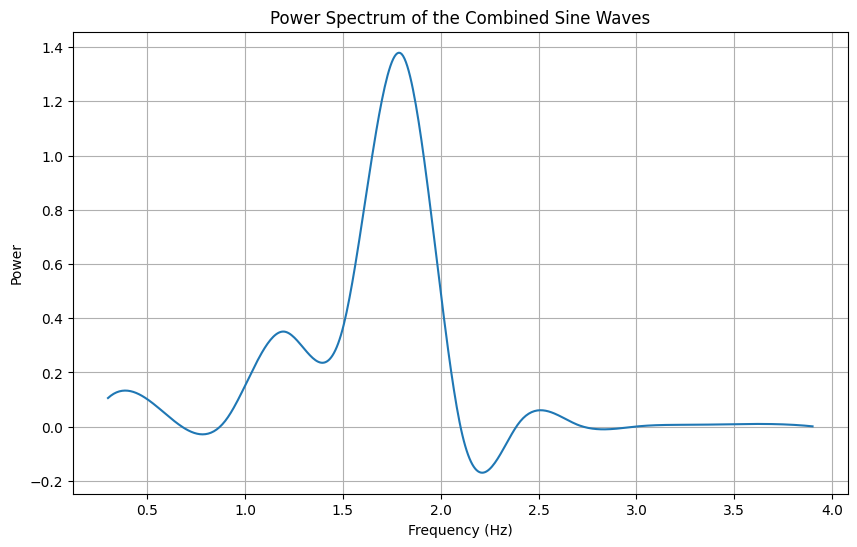

(1, 3, 100)


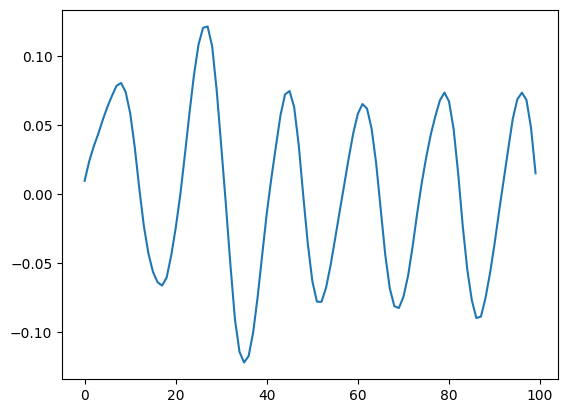

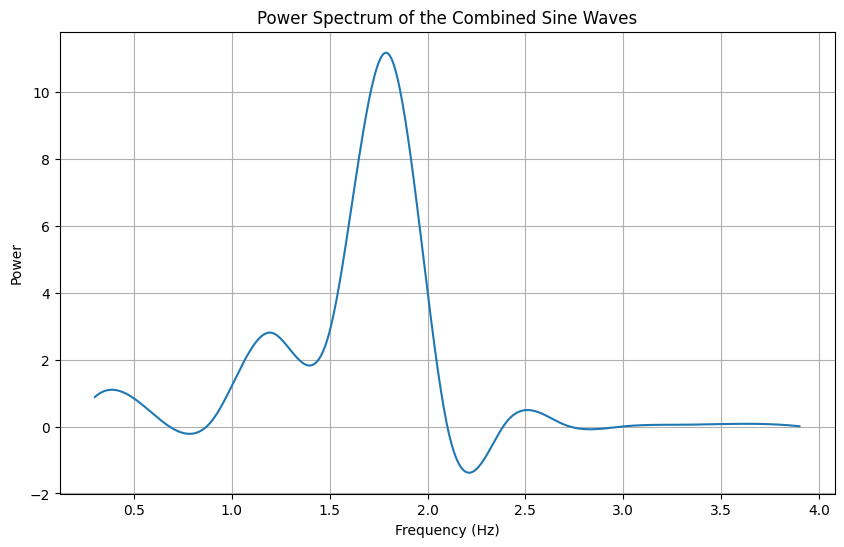

In [24]:
result = []
for i in ['POS', 'CHROM','GREEN', 'ICA', 'PBV','LGI']: # apply the different algorithm on the same ROI
  result.append(algorithm(signal_RGB,ROI_tensor_im, method=i))
df.loc[1:,selected_roi] = result

In [25]:
#df.to_csv(filename, index=False)

In [26]:
df

,fore_head,cheek_sx,cheek_dx
0,107.170341,107.170341,107.170341
1,104.140281,NaN,NaN
2,102.655311,NaN,NaN
3,108.036072,NaN,NaN
4,105.871743,NaN,NaN
5,107.170341,NaN,NaN
6,107.170341,NaN,NaN
